# Exploratory Data Analysis

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline

A description of the dataset lists the attributes and their descriptions:

##### Client Attributes
* age (numeric)
* job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
* marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
* education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
* default: has credit in default? (categorical: "no","yes","unknown")
* housing: has housing loan? (categorical: "no","yes","unknown")
* loan: has personal loan? (categorical: "no","yes","unknown")

##### Last Telephone Contact
* contact: contact communication type (categorical: "cellular","telephone") 
* month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
* day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
* duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

##### Other Attributes
* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* previous: number of contacts performed before this campaign and for this client (numeric)
* poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

##### Social and Economic Context
* emp.var.rate: employment variation rate - quarterly indicator (numeric)
* cons.price.idx: consumer price index - monthly indicator (numeric)     
* cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
* euribor3m: euribor 3 month rate - daily indicator (numeric)
* nr.employed: number of employees - quarterly indicator (numeric)

## Data

Import the data and calculate the class prevalence.  Create a test set for evaluation that will not be included in this analysis.

In [3]:
df = pd.read_csv('../data/bank-additional/bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Calculate current and previous campaign success rates

In [21]:
poutcomes = df[df.poutcome != 'nonexistent'].poutcome.apply(lambda x: 1 if x == 'success' else 0)
coutcomes = df.y.apply(lambda x: 1 if x == 'yes' else 0)

print('Number of records:', len(df))
print('Success Rate (Current Campaign):', coutcomes.sum() / len(df))
print('Success Rate (Previous Campaign):', poutcomes.sum() / len(poutcomes))

Number of records: 41188
Success Rate (Current Campaign): 0.11265417111780131
Success Rate (Previous Campaign): 0.24408888888888888


11.2% response rate in the population.  Apply stratified sampling to preserve the distribution in test and training sets.  Note that the data are ordered by date so we'll need to first shuffle the dataset rather than simply splitting it.

In [5]:
X, y = df.drop('y', axis=1), df.y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y, shuffle=True, test_size=.2)

In [6]:
print('Number of training records:', len(X_train))
print('Training proportions:\n\n', y_train.value_counts() / len(y_train))

Number of training records: 32950
Training proportions:

 no     0.887344
yes    0.112656
Name: y, dtype: float64


In [7]:
print('Number of test records:', len(X_test))
print('Training proportions:\n\n', y_test.value_counts() / len(y_test))

Number of test records: 8238
Training proportions:

 no     0.887351
yes    0.112649
Name: y, dtype: float64


Save the training and test sets

In [8]:
df_test = pd.concat([X_test, y_test], axis=1)
print('Test dataset shape:', df_test.shape)
df_test.to_csv('../data/test.csv', sep=',', index=False)

Test dataset shape: (8238, 21)


In [9]:
bank = pd.concat([X_train, y_train], axis=1)
print('Train dataset shape:', bank.shape)
bank.to_csv('../data/train.csv', sep=',', index=False)

Train dataset shape: (32950, 21)


So we should expect 10 numeric and 11 categorical attributes.

In [10]:
bank.dtypes.groupby(bank.dtypes).size()

int64       5
float64     5
object     11
dtype: int64

In [11]:
dtypes = pd.DataFrame(bank.dtypes.rename('type')).reset_index().astype('str')
# Exclude duration since it is a leaky variable
dtypes = dtypes.query('index != "duration"')
numeric = dtypes[(dtypes.type.isin(['int64', 'float64'])) & (dtypes['index'] != 'duration')]['index'].values
categorical = dtypes[~(dtypes['index'].isin(numeric)) & (dtypes['index'] != 'y')]['index'].values

print('Numeric:\n', numeric)
print('Categorical:\n', categorical)

Numeric:
 ['age' 'campaign' 'pdays' 'previous' 'emp.var.rate' 'cons.price.idx'
 'cons.conf.idx' 'euribor3m' 'nr.employed']
Categorical:
 ['job' 'marital' 'education' 'default' 'housing' 'loan' 'contact' 'month'
 'day_of_week' 'poutcome']


## Analysis

### Categorical Data Analysis

Any missing values?

In [12]:
bank[categorical].isnull().sum()

job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
poutcome       0
dtype: int64

How are values distributed accross categorical attributes?

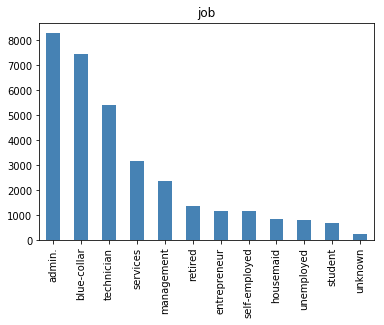

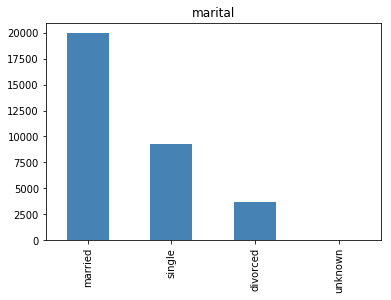

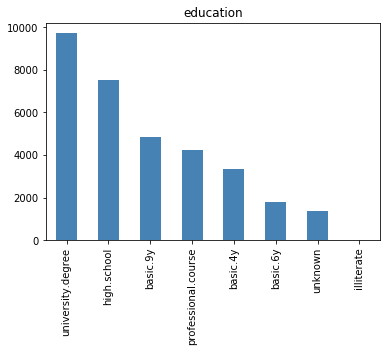

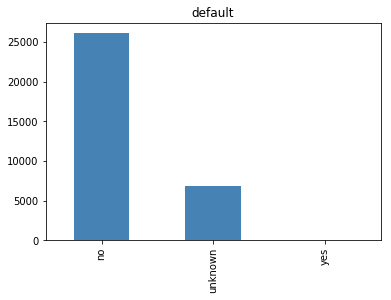

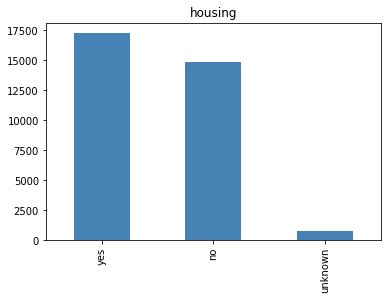

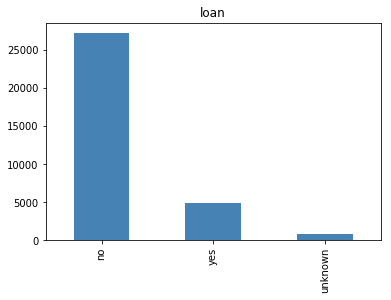

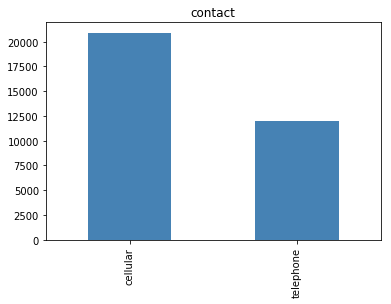

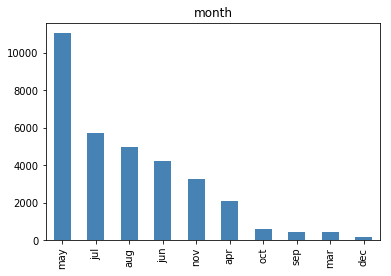

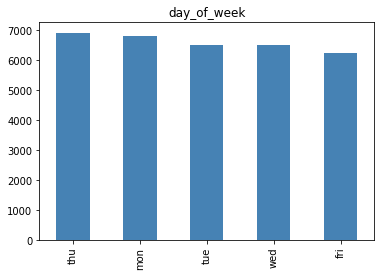

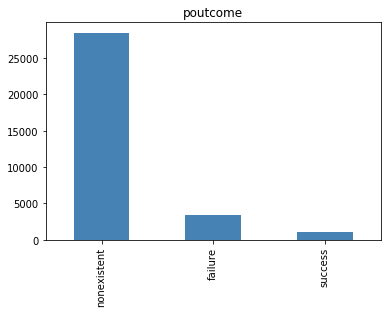

In [14]:
for attr in categorical:
  plt.figure()
  bank[attr].value_counts().plot(kind='bar', color='steelblue');
  plt.title(attr);

* There are fewer "non-traditional" jobs that could be merged if support is too low to be valuable
* The bank has a good understanding of marital status
* No or very few customers are illiterate
* No or very few customers who have defaulted on a loan - not surprising, the bank probably does not want to extend an offer to customers with bad credit
* Similar proportions of customers with and without housing loans
* Few customers have personal loans
* Almost double as many cellular as landline phone calls
* Fewer calls made in the second half of the year
* Calls are uniform accross days of the week
* Some customers were already contacted previously by the bank but many were never contacted at all

Support (job)

admin.           8279
blue-collar      7430
technician       5419
services         3155
management       2351
retired          1362
entrepreneur     1173
self-employed    1162
housemaid         861
unemployed        800
student           697
unknown           261
Name: job, dtype: int64 

Support (marital)

married     19925
single       9287
divorced     3668
unknown        70
Name: marital, dtype: int64 

Support (education)

university.degree      9722
high.school            7546
basic.9y               4860
professional.course    4234
basic.4y               3365
basic.6y               1815
unknown                1393
illiterate               15
Name: education, dtype: int64 

Support (default)

no         26089
unknown     6858
yes            3
Name: default, dtype: int64 

Support (housing)

yes        17259
no         14906
unknown      785
Name: housing, dtype: int64 

Support (loan)

no         27203
yes         4962
unknown      785
Name: loan, dtype: int64 

Sup

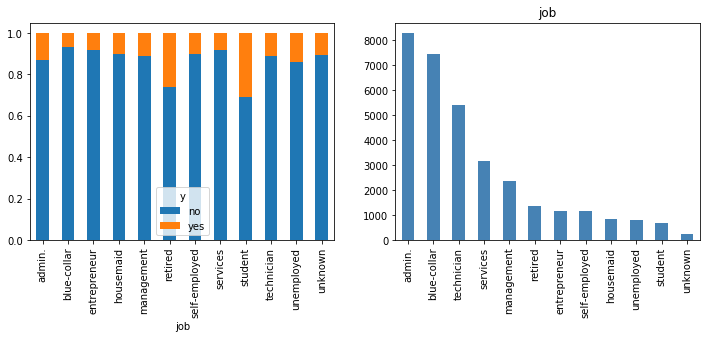

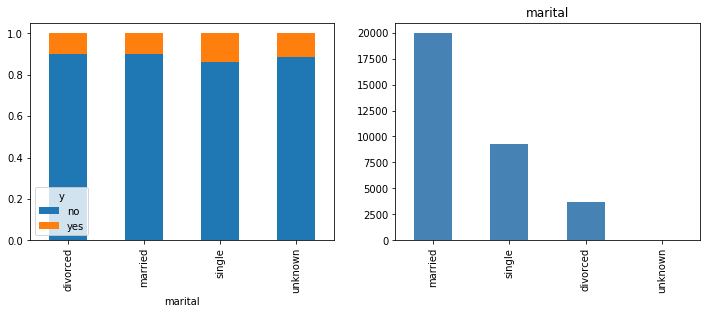

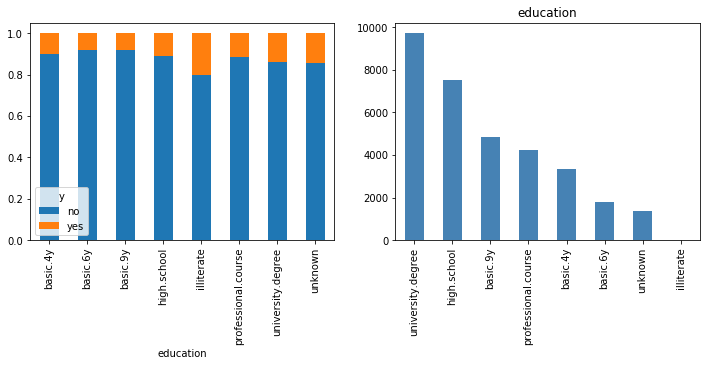

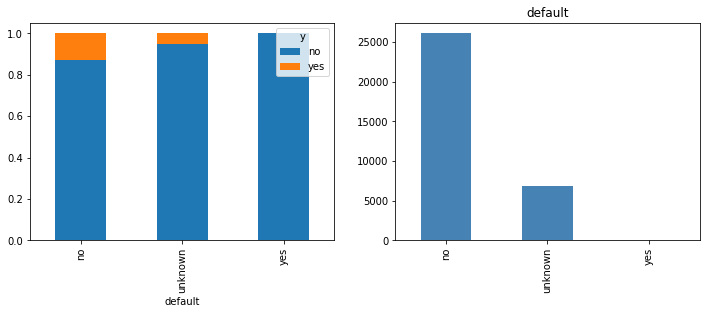

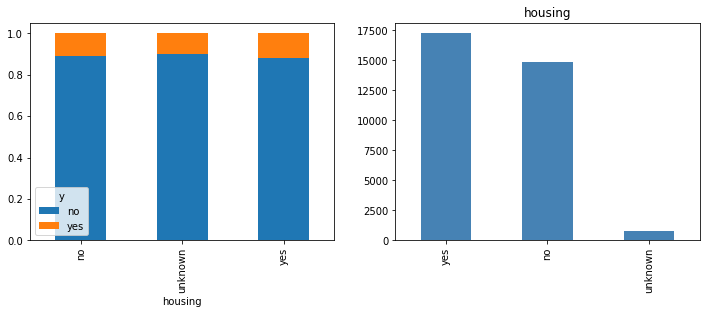

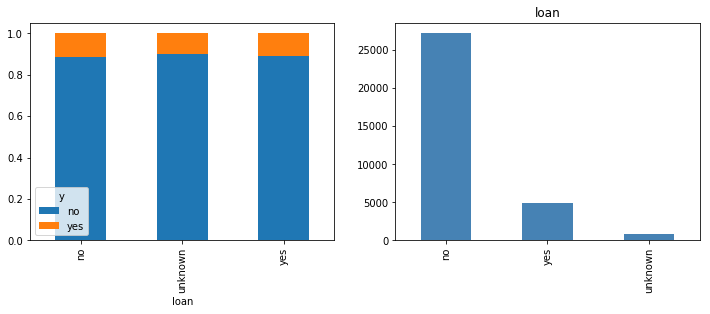

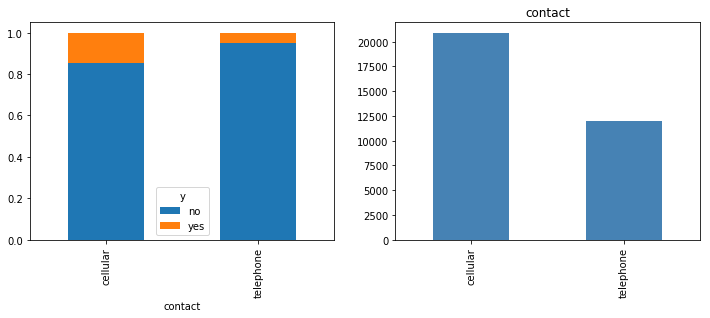

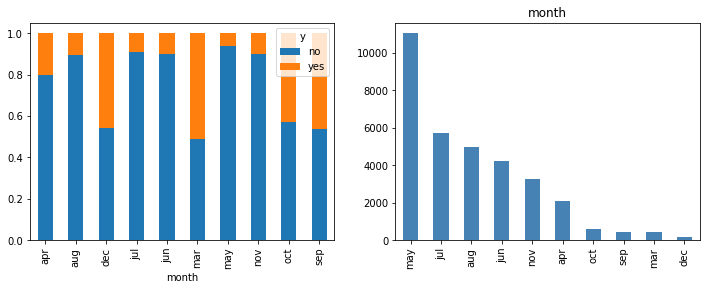

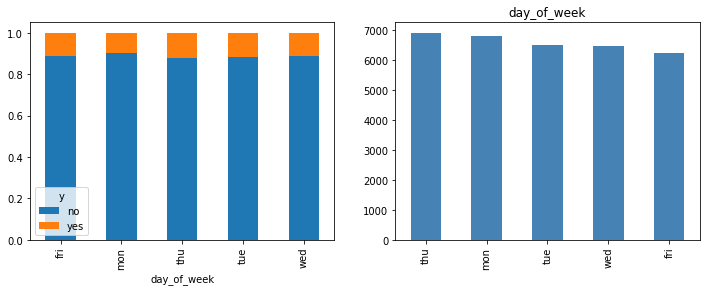

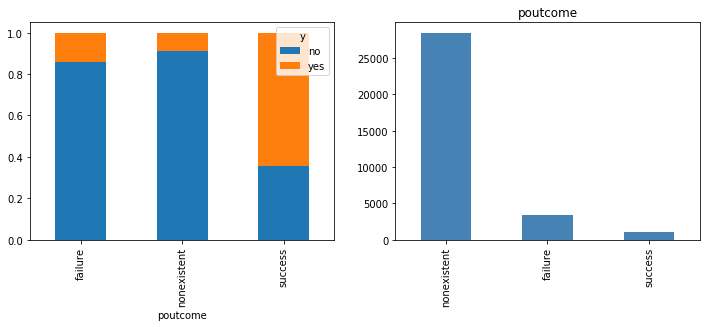

In [15]:
for attr in categorical:
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
  outcome_counts = bank.groupby([attr, 'y']).size().rename('count').reset_index()
  by_outcome = outcome_counts.pivot(columns='y', values='count', index=attr)
  # Plot the proportions
  by_outcome.div(by_outcome.sum(1), axis=0).plot.bar(stacked=True, ax=ax1);
  # Plot the counts
  bank[attr].value_counts().plot.bar(ax=ax2, legend=False,color='steelblue');
  print('Support (%s)\n' % attr)
  print(bank[attr].value_counts(), '\n')
  plt.title(attr);

In [16]:
marital_resp_rates = (bank.groupby('marital').y.value_counts() / bank.groupby('marital').size()).rename('rate').reset_index()
marital_pos_rates = marital_resp_rates.query('y == "yes"')
marital_pos_rates

,marital,y,rate
1,divorced,yes,0.101145
3,married,yes,0.101782
5,single,yes,0.140519
7,unknown,yes,0.114286


* Customers with admin, retired, student, and unemployed values tend to respond more.  Retired, student, and unemployed have lower support.
* `marital` status isn't very predictive of outcome
* Illiterate customers have a noticably higher response rate but there are few of them
* `default` appears to have predictive power (large proportion of 'no' instances)
* `contact` medium appears to have good predictive power - nearly 4x increase in conversion rate for customers who were contacted on their mobile phone
* `month` of contact appears to be predictive but low support for months with higher response rates
* `day_of_week` doesn't appear to be very informative
* If customers were contacted at least once before, they are more likely to convert (regardless of whether the last call was a success or failure)

Several attributes (`job`, `marital`, `education`, `default`, `housing`, `loan`) contain a missing value.  For all variables except for `default`, the support of the 'unknown' value is low and the associated response rate is similar to that of other known values, indicating that we probably don't need to apply any missing value techniques to these variables.

### Numerical Data Analysis

Missing values?

In [67]:
bank[numeric].isnull().sum()

age               0
campaign          0
pdays             0
previous          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
dtype: int64

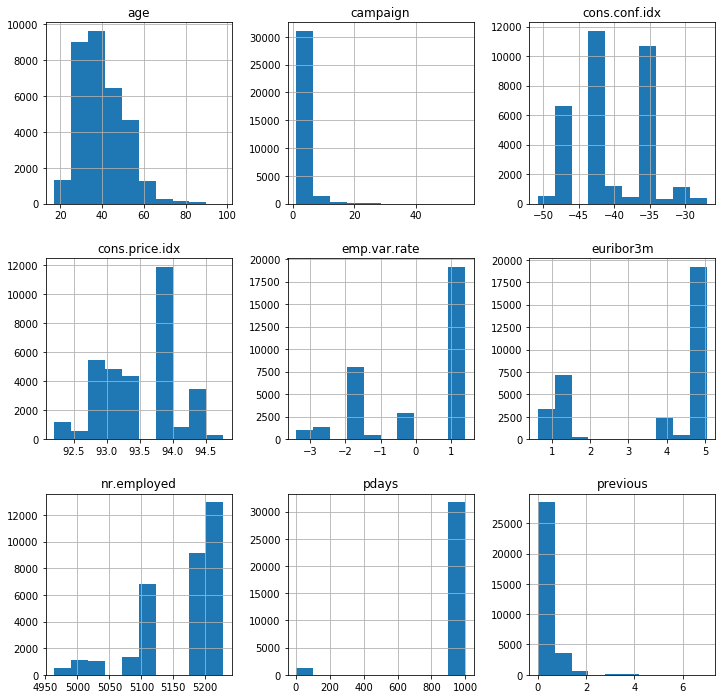

In [17]:
bank[numeric].hist(figsize=(12,12));

In [18]:
bank[numeric].describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000
mean,40.048983,2.567648,962.414021,0.173080,0.079347,93.573330,-40.497939,3.618948,5166.964003
std,10.447702,2.778174,187.064504,0.497709,1.571305,0.579098,4.636680,1.734956,72.220794
min,17.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


* Cleary some outliers who are very old - are they really representative of the popuplation or will they skew the results?  Conversely, are the outliers informative of the outcome?
* The rest of the distributions except for `campaign` and `previous` are sparse
* `previous` could be treated as a discrete variable

The fact that a majority of instances have a `pdays` value of 999 (missing) is going to be problematic if we want to use the attribute as a model feature.  Since so few instances have an associated `pdays`, we *could* remove it from the analysis and modelling process.  We could also simply add an indicator that indicates whether or not a customer was previously contacted.

What does the distribution of `pdays` look like without missing instances?

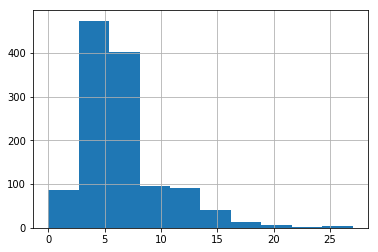

In [19]:
pdays = bank.loc[bank.pdays != 999, ['pdays', 'y']]
pdays.pdays.hist();

Is the missing value informative?

In [20]:
pdays_999 = bank.query('pdays == 999')
pdays_999.groupby('y').size() / len(pdays_999)

y
no     0.907235
yes    0.092765
dtype: float64

In [21]:
pdays.groupby('y').size() / len(pdays)

y
no     0.367381
yes    0.632619
dtype: float64

The response rate is significantly higher for customers with an associated `pdays` value (they were previously contacted).  Customers who were previously contacted are seven times more likely to convert than customers without an associated value.  It could be that these customers were previously contacted because it was already found that they had higher response rates / the previous campaign might have leveraged a similar predictive model to identify which customers to contact.

Evaluate the correlation between bank numeric attributes using Spearman rank correlation since the data isn't normal.

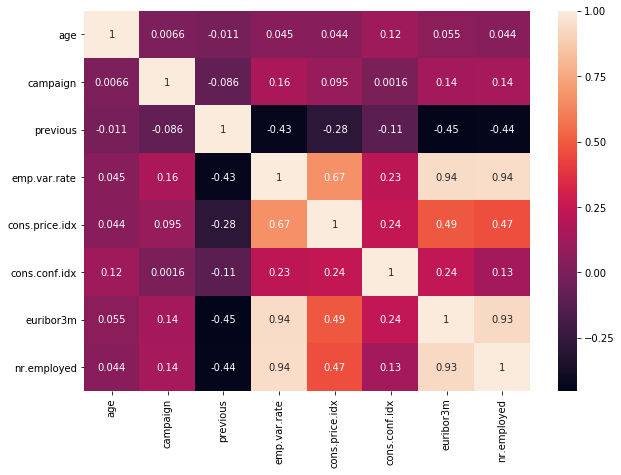

In [21]:
plt.figure(figsize=(10,7));
sns.heatmap(bank[numeric].drop('pdays', axis=1).corr('spearman'), annot=True);

Strongest correlations are between the socioeconomic attributes

/anaconda3/envs/py35-ds/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

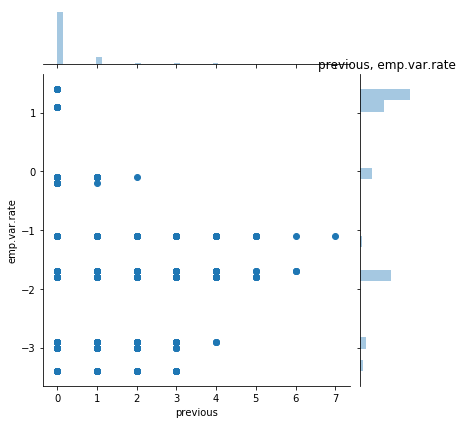

<Figure size 432x288 with 0 Axes>

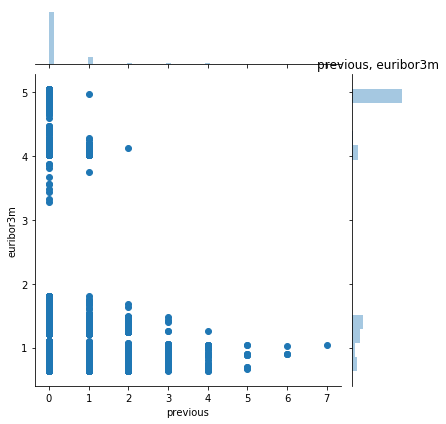

<Figure size 432x288 with 0 Axes>

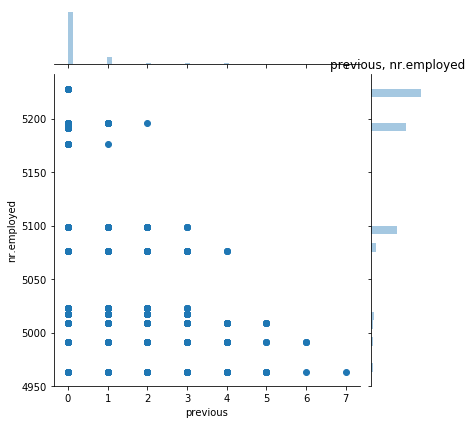

<Figure size 432x288 with 0 Axes>

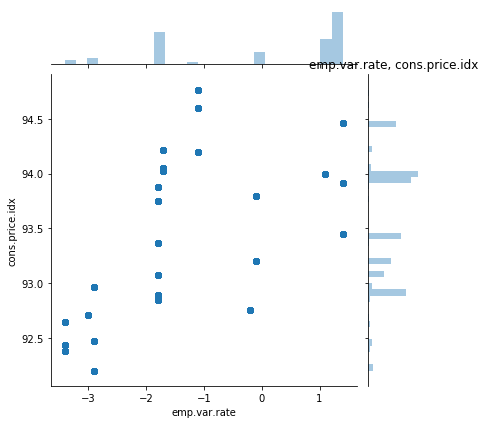

<Figure size 432x288 with 0 Axes>

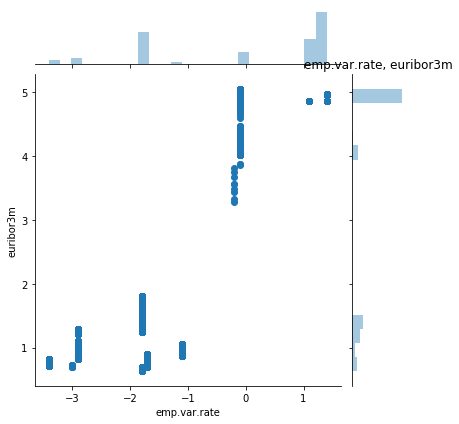

<Figure size 432x288 with 0 Axes>

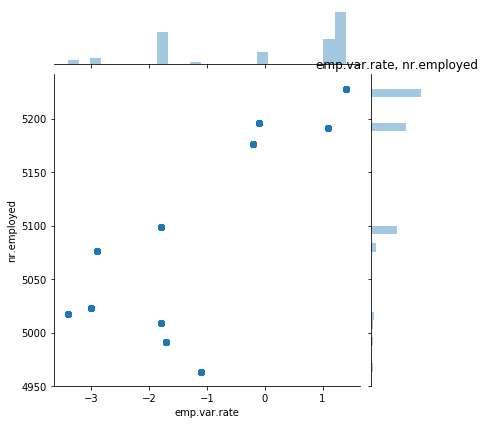

<Figure size 432x288 with 0 Axes>

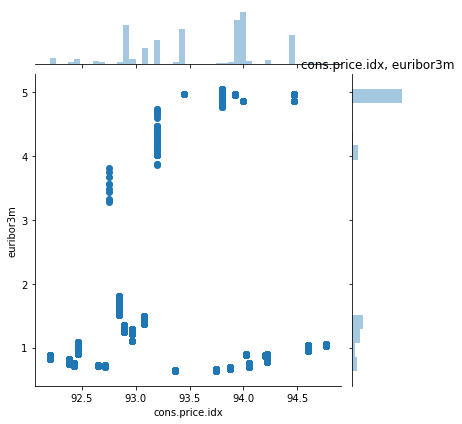

<Figure size 432x288 with 0 Axes>

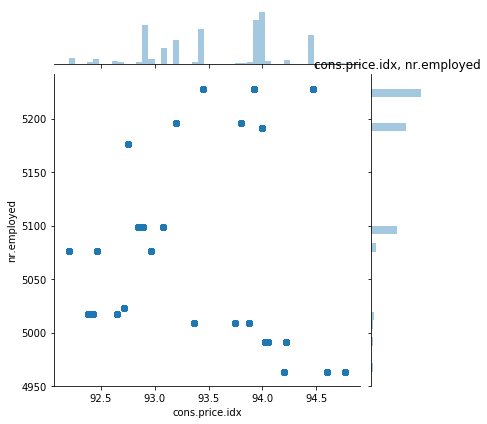

<Figure size 432x288 with 0 Axes>

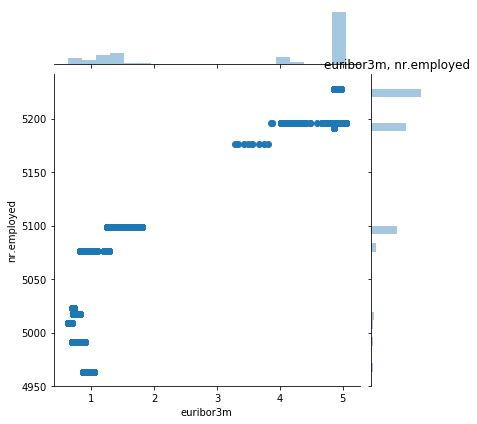

In [22]:
signif_corrs = [
  ('previous', 'emp.var.rate'),
  ('previous', 'euribor3m'),
  ('previous', 'nr.employed'),
  ('emp.var.rate', 'cons.price.idx'),
  ('emp.var.rate', 'euribor3m'),
  ('emp.var.rate', 'nr.employed'),
  ('cons.price.idx', 'euribor3m'),
  ('cons.price.idx', 'nr.employed'),
  ('euribor3m', 'nr.employed')
]

for x, y in signif_corrs:
  plt.figure();
  sns.jointplot(bank[x], bank[y]);
  plt.title('%s, %s' % (x, y));

Corerlations between socioeconmic and `previous` variables are not meaningful but correlations between socioeconmic attributes are, especially between:

* `emp.var.rate` (employment variation rate) and `cons.price.idx` (consumer price index)
* `emp.var.rate` and `euribor3m` (euriboro 3 month rate)
* `emp.var.rate` and `nr.employed` (number of employees)
* `nr.employed` and `euribor3m`

We'll need to determine which variables are most predictive as features and drop the less predictive features to eliminate multicollinearity.

#### Customer Attributes

In [23]:
cust_attrs = ['age', 'campaign', 'previous', 'y']

/anaconda3/envs/py35-ds/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


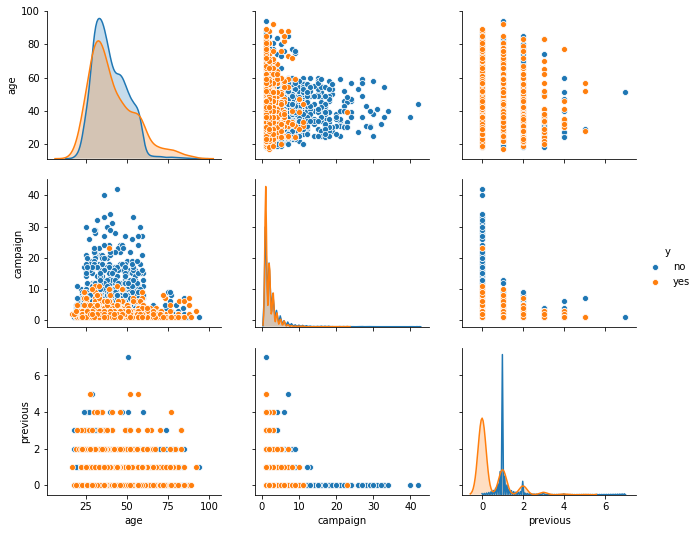

In [24]:
numeric_outcome = pd.concat([bank[numeric], bank['y']], axis=1)
sns.pairplot(numeric_outcome[cust_attrs].sample(n=10000), hue='y', aspect=1.2);

Between the ages of 18 and ~62, customers who were contacted more than ten times were not likely to respond to the campaign.  Are customers that were contacted less than 10 times more likely to convert?

In [25]:
campaign_lt10 = bank[bank.campaign < 10]
campaign_lt10.groupby('y').size() / len(campaign_lt10)

y
no     0.885293
yes    0.114707
dtype: float64

In [26]:
campaign_gte10 = bank[bank.campaign >= 10]
campaign_gte10.groupby('y').size() / len(campaign_gte10)

y
no     0.962372
yes    0.037628
dtype: float64

Customers who were contacted less than 10 times were nearly 4x more likely to convert.

/anaconda3/envs/py35-ds/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


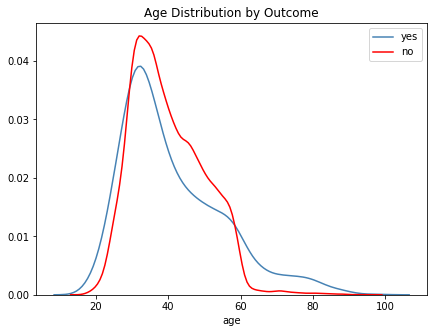

In [30]:
plt.figure(figsize=(7,5))
sns.distplot(numeric_outcome.loc[numeric_outcome.y == 'yes', 'age'], hist=False, color='steelblue', label='yes');
sns.distplot(numeric_outcome.loc[numeric_outcome.y == 'no', 'age'], hist=False, color='red', label='no');
plt.legend();
plt.title('Age Distribution by Outcome');

Younger and older customers tend to convert more than middle-aged customers, presumably because they are looking to build savings and are looking to invest capital, respectively.

/anaconda3/envs/py35-ds/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


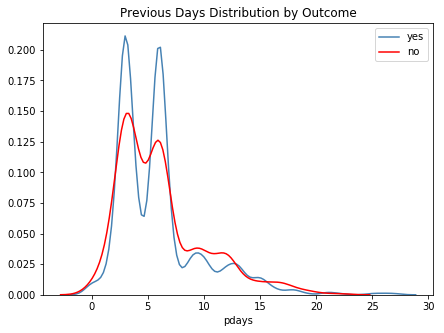

In [31]:
plt.figure(figsize=(7,5))
sns.distplot(pdays.loc[pdays.y == 'yes', 'pdays'], hist=False, color='steelblue', label='yes');
sns.distplot(pdays.loc[numeric_outcome.y == 'no', 'pdays'], hist=False, color='red', label='no');
plt.legend();
plt.title('Previous Days Distribution by Outcome');

In [32]:
pdays_resp_rates = (pdays.groupby('pdays').y.value_counts() / pdays.groupby('pdays').size()).rename('rate').reset_index()
pdays_pos_rates = pdays_resp_rates.query('y == "yes"').sort_values('rate', ascending=False)
pdays_pos_rates

,pdays,y,rate
46,27,yes,1.000000
45,26,yes,1.000000
44,25,yes,1.000000
41,21,yes,1.000000
26,13,yes,0.785714
30,15,yes,0.722222
0,0,yes,0.692308
12,6,yes,0.686217
6,3,yes,0.675362
36,18,yes,0.666667


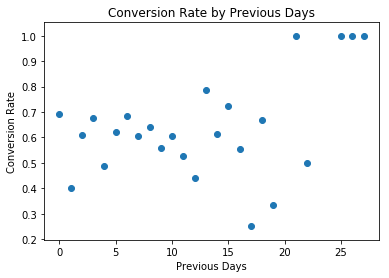

In [33]:
plt.scatter(pdays_pos_rates.pdays, pdays_pos_rates.rate)
plt.title('Conversion Rate by Previous Days');
plt.xlabel('Previous Days');
plt.ylabel('Conversion Rate');

There is nothing especially informative about the `pdays` attribute since values are randomly distributed about the conversion rate. Conversion rates are both higher and lower after ~15 days.

#### Social and Economic Context Attributes

A consideration for the socioeconomic variables is that they are computed over different frequencies e.g. quarterly, monthly, daily.

In [27]:
soc_attrs = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [ ]:
soc_ec = pd.concat([bank[soc_attrs], bank['y']], axis=1)
sns.pairplot(soc_ec, hue='y', aspect=1.2);

/anaconda3/envs/py35-ds/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


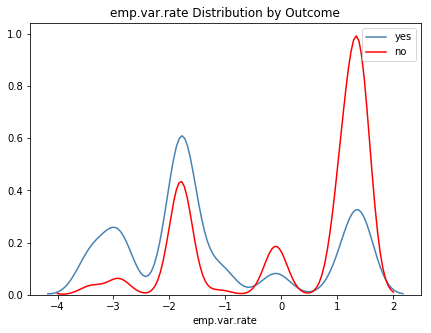

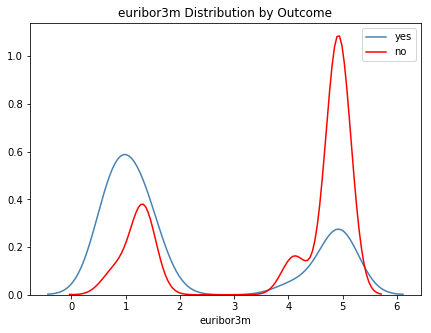

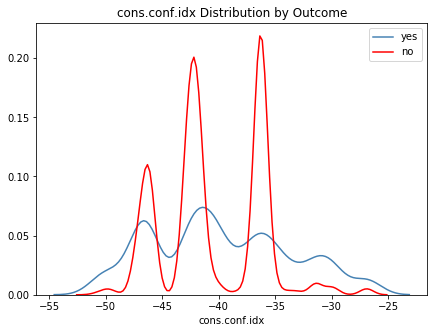

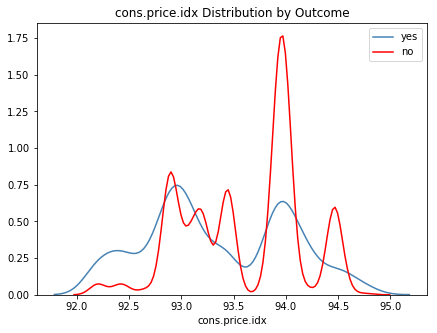

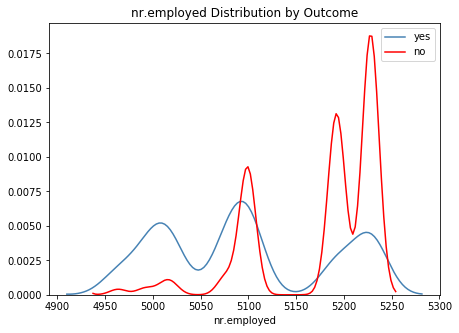

In [29]:
for c in set(soc_ec.columns) - set('y'):
  plt.figure(figsize=(7,5))
  sns.distplot(soc_ec.loc[soc_ec.y == 'yes', c], hist=False, color='steelblue', label='yes');
  sns.distplot(soc_ec.loc[soc_ec.y == 'no', c], hist=False, color='red', label='no');
  plt.legend();
  plt.title('%s Distribution by Outcome' % c);

* Customers are more likely to convert when: 
    * The employment variation rate is low
    * Euribor 3-month rate is low
    * Consumer confidence index is low or high
    * Consumer price index is high
    * Number of employees is low
* All of these attributes appear to be informative since the campaign response rate varries across their ranges of values

### Exploratory Questions

#### Estimate the conversion rate at 95% confidence

Take a random sample 10% of the training set to estimate the true conversion rate at 95% confidence.

In [44]:
x_y = bank.y.sample(frac=.09, random_state=1)
x_y_n_instances = len(x_y)
x_y_yes_n = len(x_y[x_y == 'yes'])
x_p = x_y_yes_n / len(x_y)

print('Number of instances: {:,}'.format(len(x_y)))
print('Number of conversions {:,}'.format(x_y_yes_n))
print('Conversion rate: {:.2f}%'.format(x_p * 100.))

Number of instances: 2,966
Number of conversions 339
Conversion rate: 11.43%


In [46]:
se = np.sqrt(x_p * (1-x_p) / len(x_y))

print('Standard error: {:.2f}'.format(se))
print('95% confidence interval for p_hat: ({:.2f}, {:.2f})'.format(x_p - se*1.96, x_p + se*1.96))

Standard error: 0.01
95% confidence interval for p_hat: (0.10, 0.13)


#### Are there an equal number of instances where a customer was not contacted as part of a previous campaign (`pdays` = 999) and had no outcome for the previous campaign (`poutcome` = 'nonexistent')?

In [47]:
n_pdays_999 = bank.query('pdays == 999').shape[0]
n_poutcome_nonexistent = bank.query('poutcome == "nonexistent"').shape[0]

print('pdays = 999: {:,}'.format(n_pdays_999))
print('poutcome = nonexistent: {:,}'.format(n_poutcome_nonexistent))

pdays = 999: 31,736
poutcome = nonexistent: 28,475


So there are more customers that were not contacted as part of a previous campaign (`pdays` = 999) than there are customers who were not included in the previous marketing campaign (`poutcome` = 'nonexistent').  This may be due to the fact that customers were not contacted prior to the last campaign but were still contacted as part of the previous campaign which would imply that `pdays` does not count the contact of the previous campaign. Alternatively, `poutcome` might not necessarily require that a customer was contacted, simply that their response from a previous campaign was tracked.

Either way, we don't have any attributes that tell us with certainty whether the customer was targeted as part of the last campaign or was simply tracked as part of it.

#### How many customers were included in the previous campaign and how many of them converted?

In [58]:
X = bank.copy()
X_prev = X[X.poutcome.isin(['success', 'failure'])]
X_prev_success = X_prev[X_prev.poutcome == 'success']
p_prev = len(X_prev) / len(X)
p_prev_success = len(X_prev_success) / len(X_prev)

print('Number of customers in previous campaign: {:,}'.format(len(X_prev)))
print('Percent of customers in previous campaign: {:.2f}%'.format(p_prev*100.))
print('Converted in previous campaign: {:,}'.format(len(X_prev_success)))
print('Prior campaign conversion rate: {:.2f}%'.format(p_prev_success*100.))

Number of customers in previous campaign: 4,475
Percent of customers in previous campaign: 13.58%
Converted in previous campaign: 1,100
Prior campaign conversion rate: 24.58%


14% of the customers in the training set were contacted for the previous campaign, 25% of which converted. What is the probability that a customer who converted in the previous campaign converts in the current campaign?

$$P(y=1 \mid poutcome=success) = \frac{P(y=1, poutcome=success)}{P(poutcome=success)}$$

In [59]:
x_y1_and_success = X[(X.y == 'yes') & (X.poutcome == 'success')]
p_y1_and_success = len(x_y1_and_success) / len(X)

print('Converted in previous and current campaign: {:,}'.format(len(x_y1_and_success)))
print('P(y=1∣poutcome=success): {:.2f}'.format(p_y1_and_success / p_prev_success))

Converted in previous and current campaign: 710
P(y=1∣poutcome=success): 0.09


What is the probability that a customer converted during the last campaign and this campaign given that that they were part of the last campaign?

$$P(y=1, poutcome=success \mid poutcome \ne nonexistent) = \frac{P(y=1, poutcome=success)}{P(poutcome \ne nonexistent)}$$

In [61]:
print('P(y=1,poutcome=success∣poutcome≠nonexistent): {:.2f}'.format(p_y1_and_success / p_prev))

P(y=1,poutcome=success∣poutcome≠nonexistent): 0.16


This is higher than the base conversion rate of 11.27%, so customers who converted previously are more likely to convert than on average. 

Take a random sample 10% of the training set (10% * 100,000 customers = 10,000) to estimate the true proportion of customers in the population

In [63]:
x = X.sample(n=10000, random_state=1)
x_prev = x[x.poutcome.isin(['success', 'failure'])]
x_y1_and_success = x[(x.y == 'yes') & (x.poutcome == 'success')]
p_hat_y1_and_success = len(x_y1_and_success) / len(x_prev)

print('Converted in previous and current campaign: {:,}'.format(len(x_y1_and_success)))
print('p_hat: {:.2f}'.format(p_hat_y1_and_success))

Converted in previous and current campaign: 201
p_hat: 0.15


In [66]:
se = np.sqrt(p_hat_y1_and_success * (1-p_hat_y1_and_success) / len(x_prev))

print('Standard error: {:.2f}'.format(se))
print('95% confidence interval for p_hat: ({:.2f}, {:.2f})'.format(p_hat_y1_and_success - se*1.96, p_hat_y1_and_success + se*1.96))

Standard error: 0.01
95% confidence interval for p_hat: (0.13, 0.17)


We can't say with confidence that the conversion rate is higher for customers who were previously targeted and converted since this confidence interval overlaps with the confidence interval for the training set conversion rate. Nonetheless, we'll continue to use the previous conversion rule as a baseline classifier.

Assuming we select all `n_targeted` customers, what is our expected profit?  Since we have fewer customers having converted in the previous campaign than the total number of customers we want to target, we will randomly choose customeres to make up for the difference.  A more sophisticated decision rule would have likely been used here had more customer attributes been available.